In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
import glob

In [ ]:
L2= glob.glob('Osteo/mask/**.png')      # List names of chosen masks
len(L2)                                 # Number of remainin masks after removing corrupted ones

529

In [ ]:
# To find Raw data related to the chosen masks

L1=[]
for l in L2:
    L1.append('Osteo/data/' + l.split('/')[-1].split ('.png')[0] + '.tif')
len (L1)

529

In [ ]:
# To make a dataframe relating the raw data to corresponding masks

df = pd.DataFrame({
    'filename': L1,
    'msk': L2
})

df.head (10)

,filename,msk
0,Osteo/data/Osteo_0.5_1_Tv32.tif,Osteo/mask/Osteo_0.5_1_Tv32.png
1,Osteo/data/Osteo_0.5_1_Tv33.tif,Osteo/mask/Osteo_0.5_1_Tv33.png
2,Osteo/data/Osteo_0.5_1_Tv34.tif,Osteo/mask/Osteo_0.5_1_Tv34.png
3,Osteo/data/Osteo_0.5_1_Tv40.tif,Osteo/mask/Osteo_0.5_1_Tv40.png
4,Osteo/data/Osteo_0.5_1_Tv38.tif,Osteo/mask/Osteo_0.5_1_Tv38.png
5,Osteo/data/Osteo_0.5_1_Tv37.tif,Osteo/mask/Osteo_0.5_1_Tv37.png
6,Osteo/data/Osteo_0.5_1_Tv41.tif,Osteo/mask/Osteo_0.5_1_Tv41.png
7,Osteo/data/Osteo_0.5_1_Tv45.tif,Osteo/mask/Osteo_0.5_1_Tv45.png
8,Osteo/data/Osteo_0.5_10_Tv32.tif,Osteo/mask/Osteo_0.5_10_Tv32.png
9,Osteo/data/Osteo_0.5_10_Tv33.tif,Osteo/mask/Osteo_0.5_10_Tv33.png


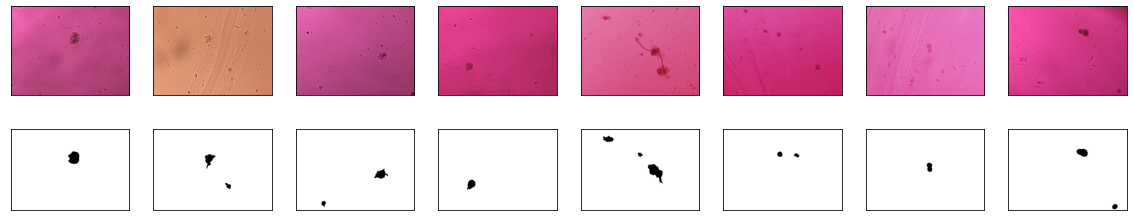

In [ ]:
# Visualize a sample of raw data and their corresponding masks

fig, ax= plt.subplots (2, 8, figsize= [20,4])
for i in range (8):
    f= np.random.randint (len(L1))
    ax[0, i].imshow (plt.imread (df.iloc[f].filename))
    ax[1, i].imshow (plt.imread (df.iloc[f].msk))

    [ax[j, i].set_xticks([]) for j in range (2)]
    [ax[j, i].set_yticks([]) for j in range (2)]

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Activation, Dense, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Dropout, BatchNormalization, Concatenate, Resizing
from tensorflow.keras.optimizers import SGD, RMSprop
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import regularizers

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from sklearn.model_selection import train_test_split

In [ ]:
INPUT_WIDTH = 1548//3
INPUT_HEIGHT = 2070//3
INPUT_SIZE = (INPUT_WIDTH, INPUT_HEIGHT)

IMAGE_CHANNELS=3

In [ ]:
drp_rate= 0.4
l2_rt= 5e-2

input = Input(shape= (INPUT_WIDTH, INPUT_HEIGHT, IMAGE_CHANNELS))

x = Conv2D(32, (3,3), activation='relu', kernel_regularizer = regularizers.l2(l2_rt))(input)
x = BatchNormalization()(x)
x_mx = MaxPooling2D((3,3))(x)
x_drp = Dropout(drp_rate)(x_mx)

x_c2 = Conv2D(32, (3,3), activation='relu', padding='same', kernel_regularizer = regularizers.l2(l2_rt))(x_drp)
x_c2 = BatchNormalization()(x_c2)
x_up = UpSampling2D((2,2))(x_c2)
x_drp2 = Dropout(drp_rate)(x_up)


x_r = Resizing(x_drp2.shape[1], x_drp2.shape[2], interpolation="bicubic")(x)
x_r = Dropout(drp_rate)(x_r)

x_conc = Concatenate (axis= -1)([x_drp2, x_r])

x_c3 = Conv2D(8, (3,3), activation='relu', 
            #   kernel_initializer='ones', 
              kernel_regularizer = regularizers.l2(l2_rt))(x_conc)
x_c3 = BatchNormalization()(x_c3)
x_c3 = Dropout(drp_rate)(x_c3)

x_out = Conv2D(1, (3,3), activation='sigmoid', kernel_regularizer = regularizers.l2(l2_rt))(x_c3)

model = Model(inputs=input, outputs=x_out)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 516, 690, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_4 (Conv2D)              (None, 514, 688, 32  896         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_3 (BatchNo  (None, 514, 688, 32  128        ['conv2d_4[0][0]']               
 rmalization)                   )                                                           

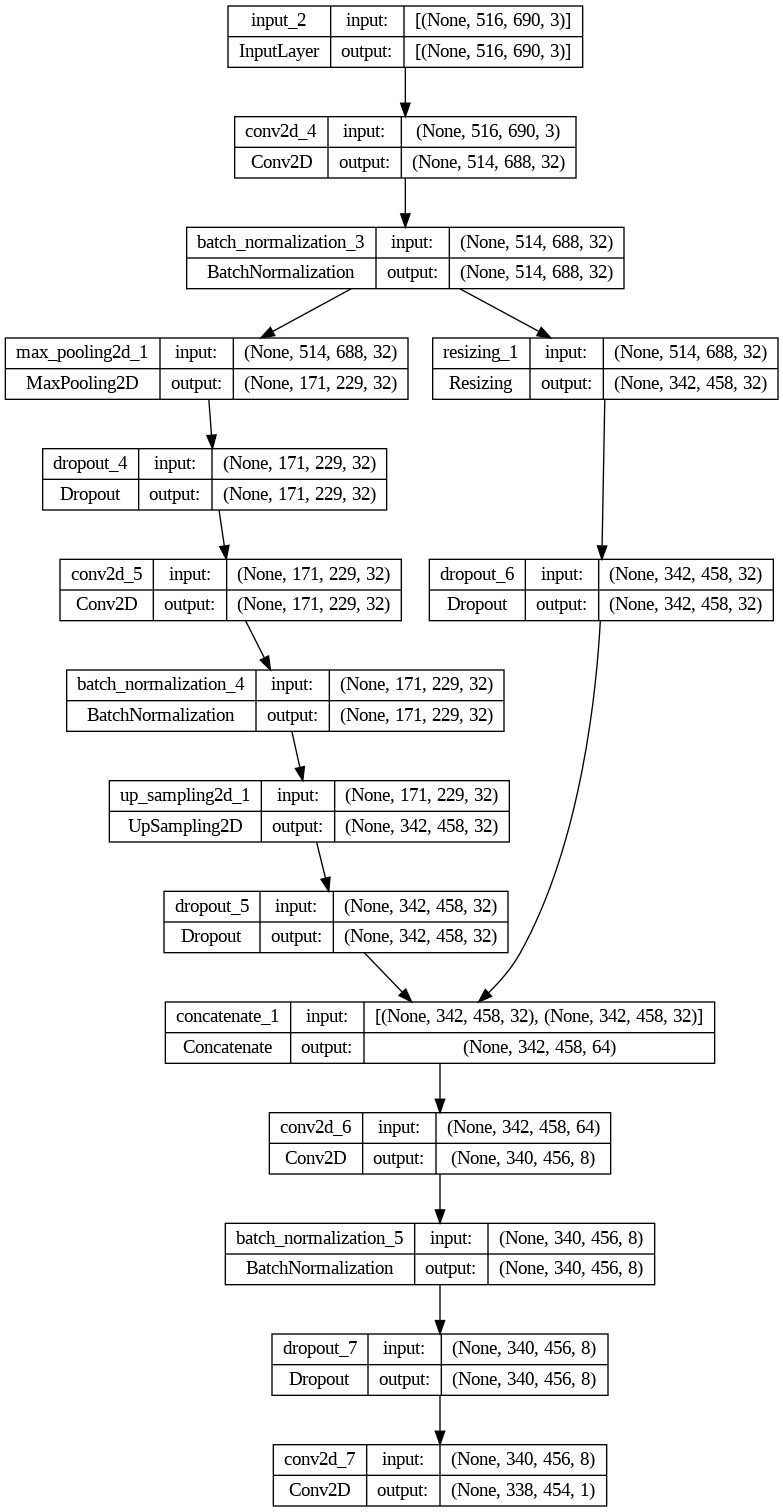

In [ ]:
print (model.summary())
plot_model (model, show_shapes=True)

In [ ]:
# To augment data by valid varietis in the dataset

def custom_augmentation(np_tensor):
 
    def random_contrast(np_tensor):
        return tf.image.random_contrast(np_tensor, 0.5, 1)
    
    def random_hue(np_tensor):
        return tf.image.random_hue(np_tensor, 0.1)
    
    def random_saturation(np_tensor):
        return tf.image.random_saturation(np_tensor, 0.5, 1)
    
    augmnted_tensor = random_contrast(np_tensor)
    augmnted_tensor = random_hue(augmnted_tensor)
    augmnted_tensor = random_saturation(augmnted_tensor)
    return np.array(augmnted_tensor)

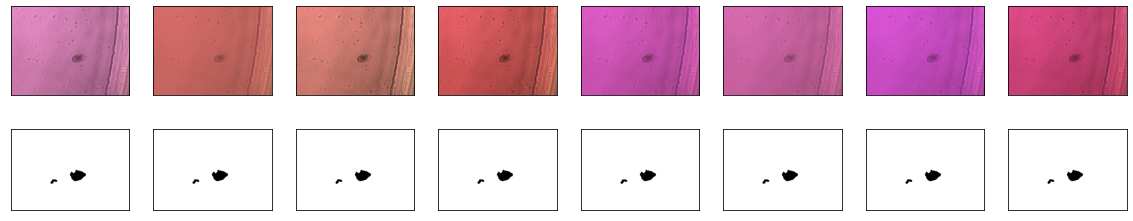

In [ ]:
fig, ax= plt.subplots (2, 8, figsize= [20,4])
f= np.random.randint (len(L1))
for i in range (8):
    
    ax[0, i].imshow (custom_augmentation(plt.imread (df.iloc[f].filename)))
    ax[1, i].imshow (plt.imread (df.iloc[f].msk))

    [ax[j, i].set_xticks([]) for j in range (2)]
    [ax[j, i].set_yticks([]) for j in range (2)]

In [ ]:
# Data generators to feed in Neural Network model

train_df, validate_df = train_test_split(df, test_size=0.25, random_state=100)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

IMAGE_SIZE=list(x_out.shape [1:3])

total_train= len(L1)
batch_size= 4
seed = 100 # Important

def prep (image):
    return 1-image
X_train_datagen = ImageDataGenerator(
    rescale=1./255,
    brightness_range=[0.8,1.0], \
    preprocessing_function=custom_augmentation
)

train_datagen = ImageDataGenerator(
    rescale=1./255, 
)

X_train_generator = X_train_datagen.flow_from_dataframe(
    train_df, 
    x_col='filename',
    # y_col='msk',
    target_size= INPUT_SIZE,
    class_mode=None,
    batch_size=batch_size,
    seed=seed
)

y_train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    x_col='msk',
    target_size=  IMAGE_SIZE,
    color_mode="grayscale",
    class_mode=None,
    batch_size=batch_size,
    seed=seed
)

train_generator = zip(X_train_generator, y_train_generator)

Found 396 validated image filenames.
Found 396 validated image filenames.


In [ ]:
X_v_generator = train_datagen.flow_from_dataframe(
    validate_df, 
    x_col='filename',
    # y_col='msk',
    target_size= INPUT_SIZE,
    class_mode=None,
    batch_size=batch_size,
    seed=seed)

y_v_generator = train_datagen.flow_from_dataframe(
    validate_df, 
    x_col='msk',
    target_size=  IMAGE_SIZE,
    color_mode="grayscale",
    class_mode=None,
    batch_size=batch_size,
    seed=seed
)
validation_generator = zip(X_v_generator, y_v_generator)


Found 133 validated image filenames.
Found 133 validated image filenames.


In [ ]:
# Dedine dice loss function, suitable for our segmentation mission. 
# Read the paper for more information on this. 

def dice_loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    numerator = 2 * tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred)

    return 1 - numerator / denominator

In [ ]:
lr= 1e-5
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.9,
                              patience=2, min_lr=1e-6)
rmsp= RMSprop(learning_rate=lr)
# sgd= SGD(learning_rate=lr)

model.compile(optimizer= rmsp, loss=dice_loss, metrics=['mae'])

early_stop = EarlyStopping(monitor='loss', min_delta=0.0001, patience=3)

history = model.fit (train_generator, epochs=20, verbose=1, 
           steps_per_epoch= 5*total_train//batch_size, callbacks=[early_stop, reduce_lr])

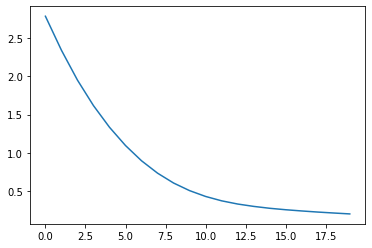

In [ ]:
# Better the model be weakly traind on the dataset. Since the aim is only to boost the training dataset for 
# another CNN, and indeed bcs the training ground truth data are not perfectly masked in general. 
# Read the paper for more information on this decision. 

plt.plot (history.history['loss'])

1/1 - 1s - 1s/epoch - 1s/step


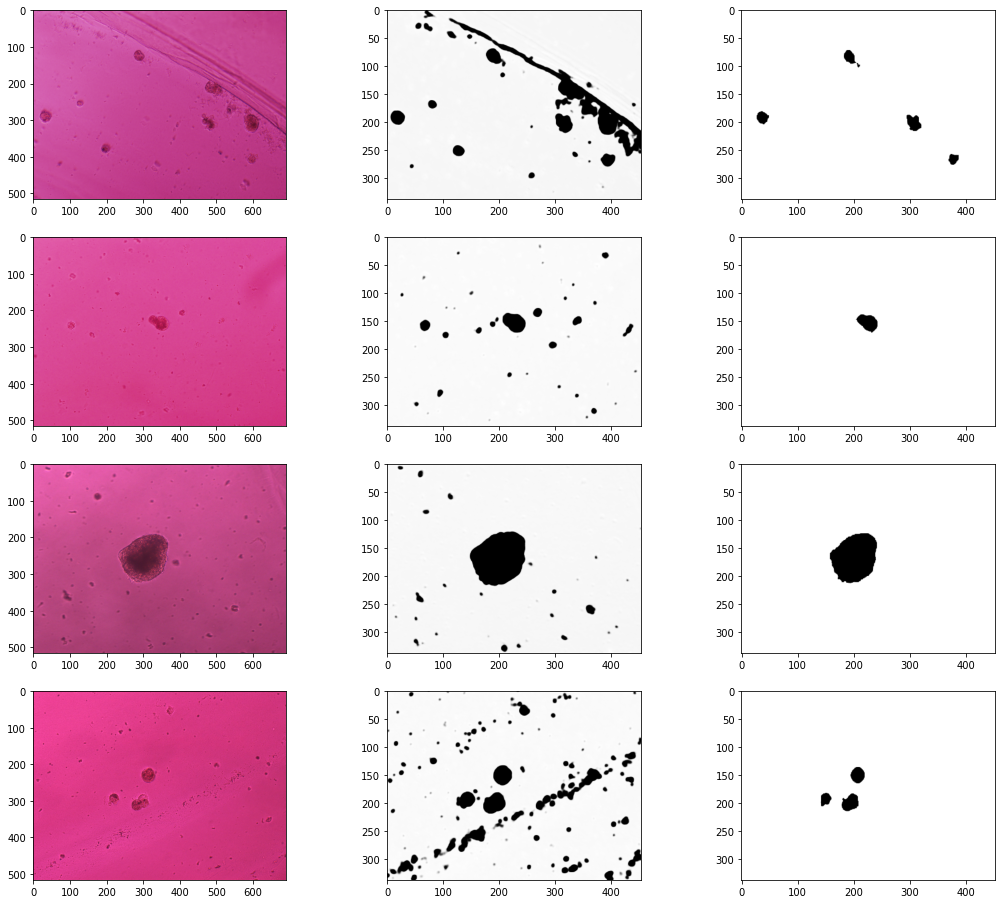

In [ ]:
# seed=100

in_imgs, imgs= next(validation_generator)
pred = model.predict (in_imgs, verbose=2)

n= 4
fig, ax= plt.subplots (n, 3, figsize=(18, 4*n))

for i in range (n):
    ax[i, 0].imshow (in_imgs[i])
    ax[i, 1].imshow (pred[i][:,:,0], cmap='gray')
    ax[i, 2].imshow (imgs[i][:,:,0], cmap='gray')

    # [ax[j, i].set_xticks([]) for j in range (2)]
    # [ax[j, i].set_yticks([]) for j in range (2)]
    
plt.show ()

Right: Input data, Middle: Shallow CNN boost (output), Left: Training mask
It is shown that without any thresholding and extra modifications, our shallow CNN is capable of outperformance on the training masks by finding more details in comparision with the mask. This is possible by the model's architecture and weakly training. 

In [ ]:
# model.save ('CNN1_v1(Best).model')

INFO:tensorflow:Assets written to: CNN1_v1(Best).model/assets
